In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
import os
import random

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"janaazd","key":"f1215fe46025c250e6b583af06ff1c33"}'}

In [8]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [9]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.26G/2.29G [00:21<00:00, 41.9MB/s]
100% 2.29G/2.29G [00:21<00:00, 115MB/s] 


In [10]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [17]:
base_dir = "chest_xray"
(train_images, train_labels ), (test_images , test_labels ) = os.listdir(os.path.join(base_dir, "train")),os.listdir(os.path.join(base_dir, "test"))

In [18]:
#first lets check our dataset
base_dir = "chest_xray"
for folder in ["train", "val", "test"]:
    path = os.path.join(base_dir, folder)
    print(folder.upper(), ":", os.listdir(path))


TRAIN : ['PNEUMONIA', 'NORMAL']
VAL : ['PNEUMONIA', 'NORMAL']
TEST : ['PNEUMONIA', 'NORMAL']


In [23]:
#now lets count images per class
def count_images(path):
    normal = len(os.listdir(os.path.join(path, "NORMAL")))
    pneumonia = len(os.listdir(os.path.join(path, "PNEUMONIA")))
    return normal, pneumonia

train_normal, train_pneumonia = count_images("chest_xray/train")
val_normal, val_pneumonia = count_images("chest_xray/val")
test_normal, test_pneumonia = count_images("chest_xray/test")

df = pd.DataFrame({
    "Set": ["Train", "Validation", "Test"],
    "Normal": [train_normal, val_normal, test_normal],
    "Pneumonia": [train_pneumonia, val_pneumonia, test_pneumonia]
})

df


,Set,Normal,Pneumonia
0,Train,1341,3875
1,Validation,8,8
2,Test,234,390


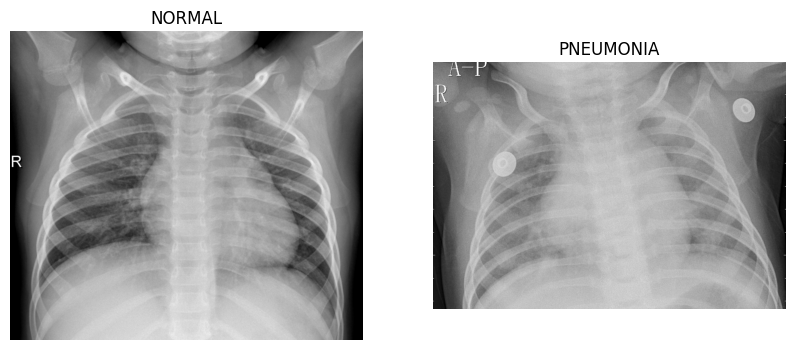

In [24]:
#lets view one random Normal and one random Pneumonia X-ray
train_dir = "chest_xray/train"
classes = ["NORMAL", "PNEUMONIA"]

plt.figure(figsize=(10,10))

for i, label in enumerate(classes):
    folder = os.path.join(train_dir, label)
    img_file = random.choice(os.listdir(folder))
    img_path = os.path.join(folder, img_file)

    img = load_img(img_path)

    plt.subplot(1, 2, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.show()


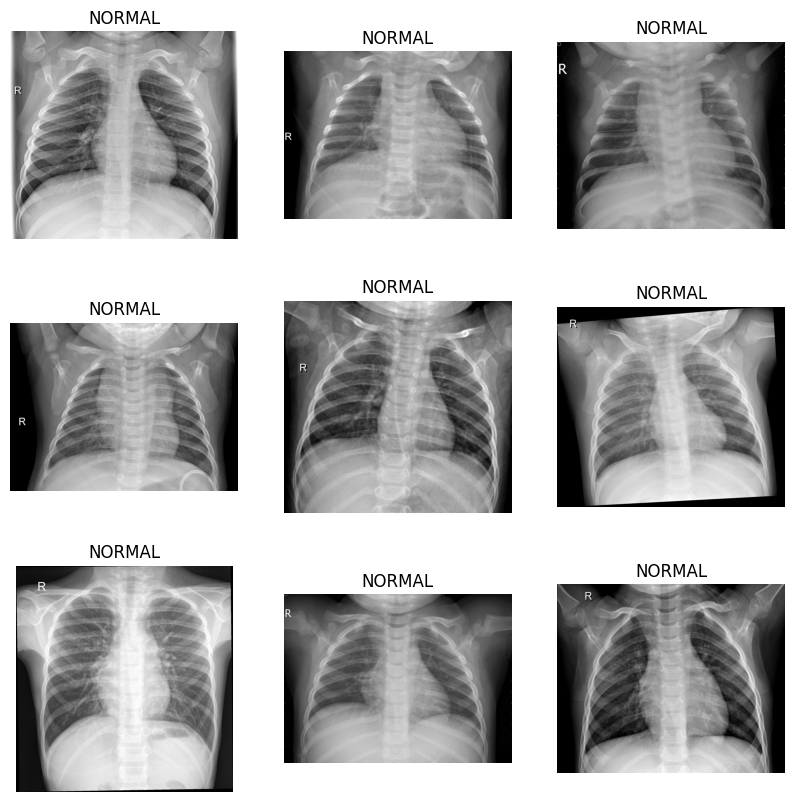

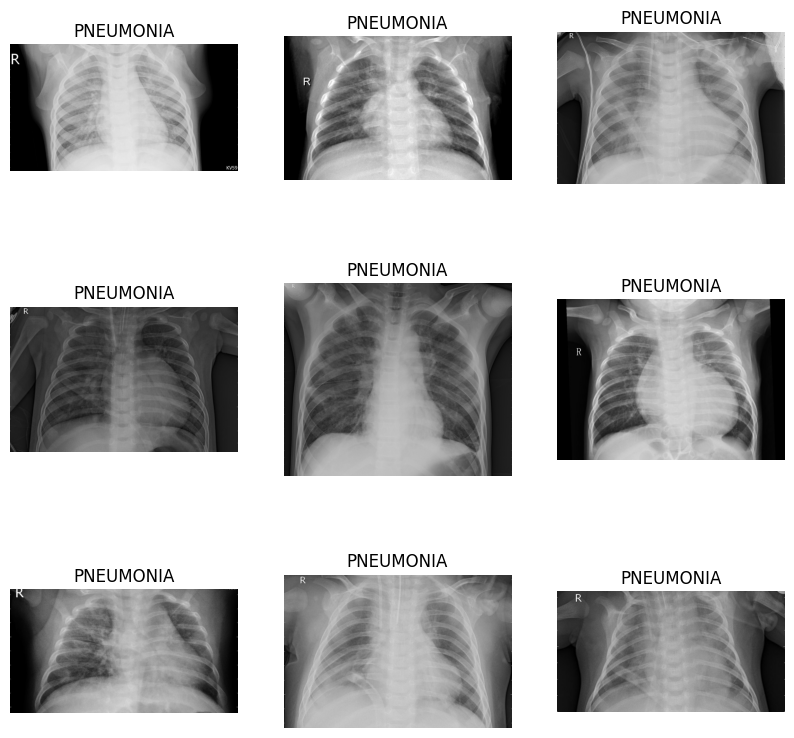

In [25]:
#these are some samples
def show_samples(class_name, n=9):
    folder = os.path.join(train_dir, class_name)
    files = random.sample(os.listdir(folder), n)

    plt.figure(figsize=(10,10))
    for i, f in enumerate(files):
        img = load_img(os.path.join(folder, f))
        plt.subplot(3,3,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(class_name)
        plt.axis('off')
    plt.show()

show_samples("NORMAL")
show_samples("PNEUMONIA")


In [47]:
img_size = 224
batch_size = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)


In [48]:
test_val_datagen = ImageDataGenerator(rescale=1./255)

In [49]:
base_dir = "/content/chest_xray"

train = train_datagen.flow_from_directory(
    base_dir + "/train",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary"
)

val = test_val_datagen.flow_from_directory(
    base_dir + "/val",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary"
)

test = test_val_datagen.flow_from_directory(
    base_dir + "/test",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


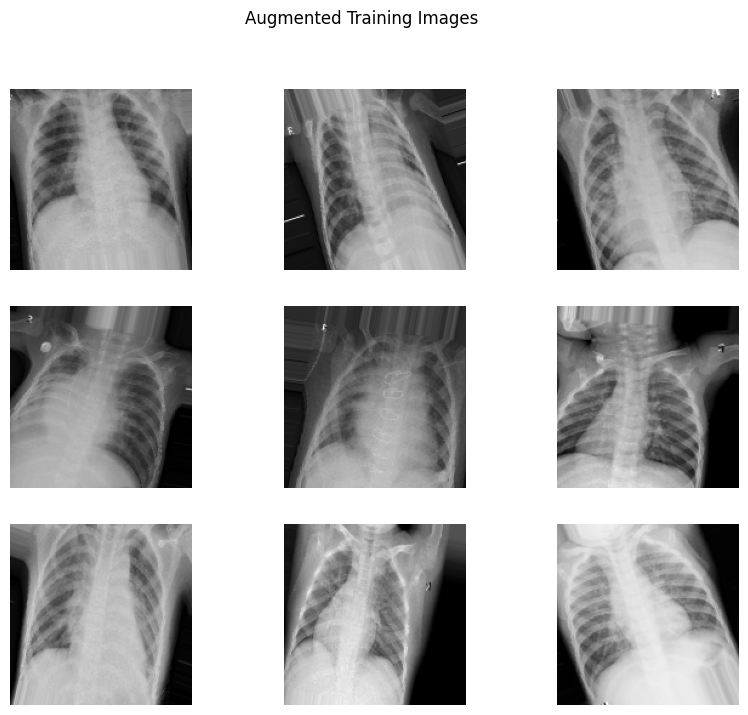

In [36]:
sample_imgs, sample_labels = next(train)

plt.figure(figsize=(10, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_imgs[i])
    plt.axis("off")
plt.suptitle("Augmented Training Images")
plt.show()


In [50]:
img_size = 224

model = Sequential([

    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')   # Binary classification
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
history = model.fit(
    train,
    validation_data=val,
    epochs=15
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 423ms/step - accuracy: 0.7337 - loss: 0.5632 - val_accuracy: 0.8125 - val_loss: 0.4964
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 66s 405ms/step - accuracy: 0.8607 - loss: 0.3020 - val_accuracy: 0.7500 - val_loss: 0.7713
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.8815 - loss: 0.2702 - val_accuracy: 0.9375 - val_loss: 0.4515
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 412ms/step - accuracy: 0.8878 - loss: 0.2654 - val_accuracy: 0.7500 - val_loss: 0.6418
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 409ms/step - accuracy: 0.9016 - loss: 0.2306 - val_accuracy: 0.8125 - val_loss: 0.4897
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 415ms/step - accuracy: 0.9166 - loss: 0.2170 - val_accuracy: 0.7500 - val_loss: 0.6164
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 414ms/step - accuracy: 0.9085 - loss: 0.2135 - val_accuracy: 0.7500 - val_loss: 0.6383
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 421ms/step - accuracy: 0.9266 - loss: 0

In [51]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Freeze convolution layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model_tf = Model(inputs=base_model.input, outputs=output)

model_tf.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_tf.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [52]:

batch_size = 32

history_tf = model_tf.fit(
    train,
    validation_data=val,
    epochs=10
)


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 125s 661ms/step - accuracy: 0.8591 - loss: 0.3207 - val_accuracy: 0.8750 - val_loss: 0.2494
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 608ms/step - accuracy: 0.9455 - loss: 0.1473 - val_accuracy: 0.8125 - val_loss: 0.2596
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 114s 698ms/step - accuracy: 0.9458 - loss: 0.1409 - val_accuracy: 0.8125 - val_loss: 0.2713
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 593ms/step - accuracy: 0.9397 - loss: 0.1455 - val_accuracy: 0.8125 - val_loss: 0.3383
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 96s 589ms/step - accuracy: 0.9533 - loss: 0.1182 - val_accuracy: 0.8125 - val_loss: 0.3110
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 608ms/step - accuracy: 0.9551 - loss: 0.1192 - val_accuracy: 0.8125 - val_loss: 0.2520
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 100s 613ms/step - accuracy: 0.9552 - loss: 0.1229 - val_accuracy: 0.8125 - val_loss: 0.4731
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 606ms/step - accuracy: 0.9558 - loss

In [53]:
from sklearn.metrics import classification_report

# Get predicted probabilities
y_pred_prob = model_tf.predict(test)

# Convert probabilities to binary labels
y_pred = (y_pred_prob > 0.5).astype(int)

# True labels
y_true = test.classes

# Classification report
print(classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))


20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 426ms/step
              precision    recall  f1-score   support

      Normal       0.92      0.74      0.82       234
   Pneumonia       0.86      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



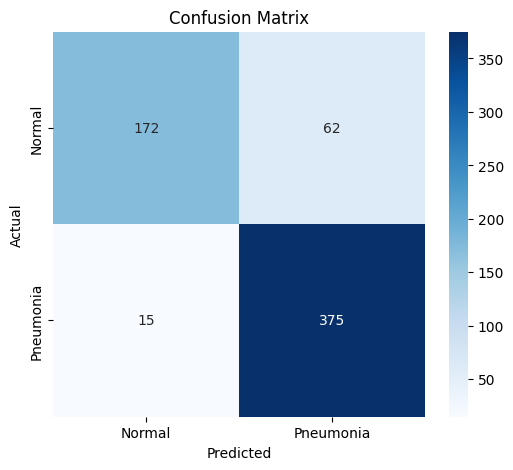

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal","Pneumonia"],
            yticklabels=["Normal","Pneumonia"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()

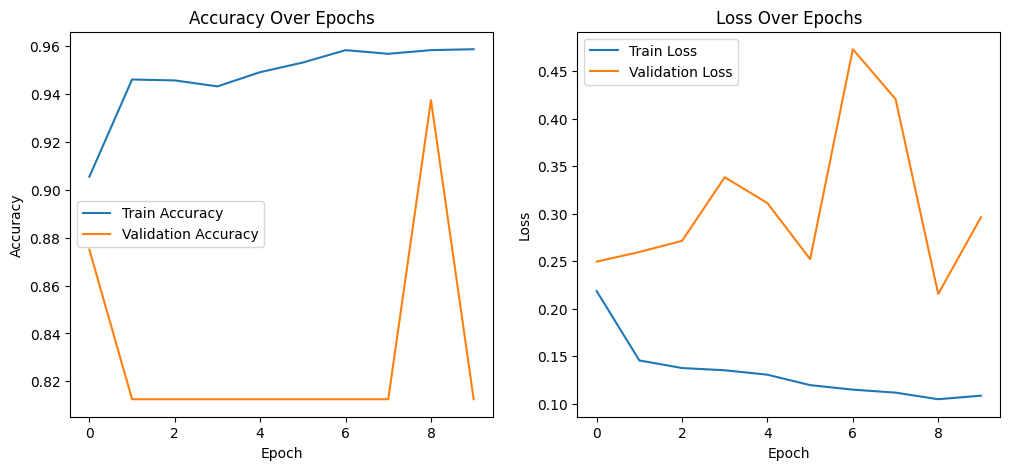

In [55]:
# Accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_tf.history['accuracy'], label='Train Accuracy')
plt.plot(history_tf.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_tf.history['loss'], label='Train Loss')
plt.plot(history_tf.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()